<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

In [2]:
pip install darts


Note: you may need to restart the kernel to use updated packages.


Check whether GPU is available

In [24]:
import torch
torch.cuda.is_available()





False

In [5]:
import pandas as pd
from darts import TimeSeries

df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv')

series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

In [6]:
from darts.models import ExponentialSmoothing

train, val = series.split_before(pd.Timestamp('19580101'))

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

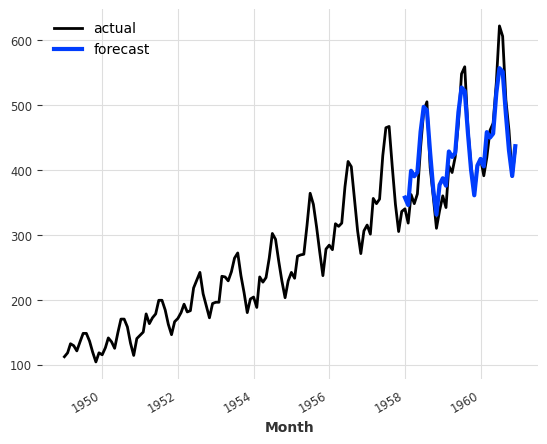

In [7]:
import matplotlib.pyplot as plt

series.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()

In [8]:
from darts.models import AutoARIMA

model_aarima = AutoARIMA()
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

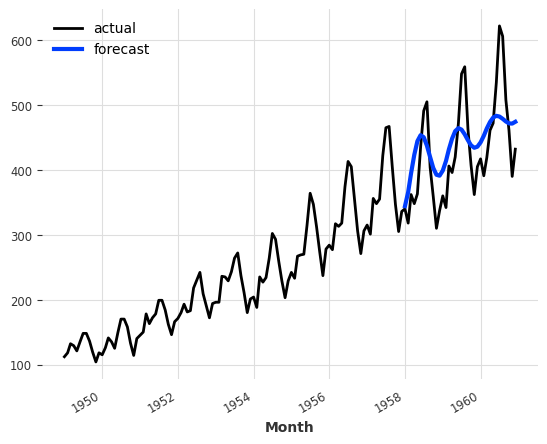

In [9]:
import matplotlib.pyplot as plt

series.plot(label='actual')
prediction_aarima.plot(label='forecast', lw=3)
plt.legend()

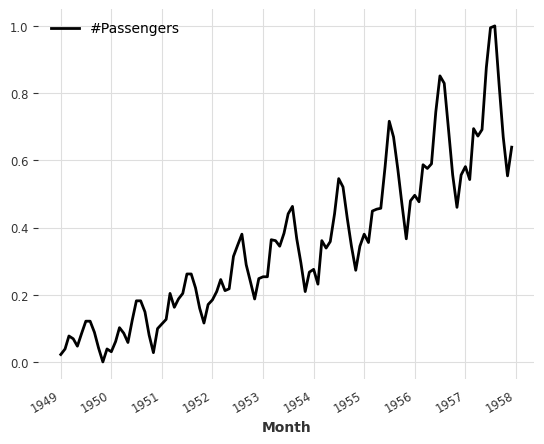

In [10]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled = scaler.fit_transform(train)

train_air_scaled.plot()

encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": Scaler()}

In [13]:
from darts.models import NHiTSModel
# increasing the number of blocks
model_nhits = NHiTSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    add_encoders=encoders,
    num_blocks=20,
    n_epochs=50,
)
model_nhits.fit(train_air_scaled)
pred_nhits = model_nhits.predict(len(val))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 18.7 M
---------------------------------------------------
18.6 M    Trainable params
36.9 K    Non-trainable params
18.7 M    Total params
74.725    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

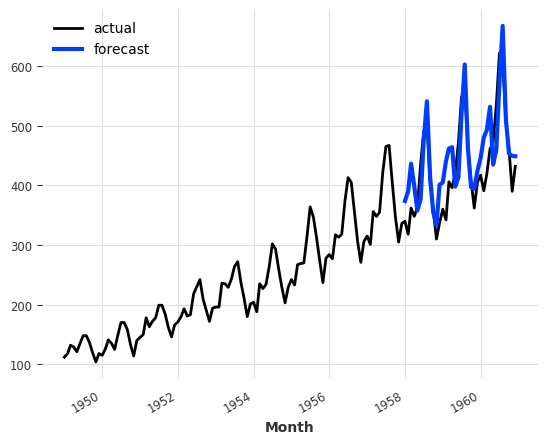

In [12]:
import matplotlib.pyplot as plt

series.plot(label='actual')

# scale back:
pred_nhits = scaler.inverse_transform(pred_nhits)

pred_nhits.plot(label='forecast', lw=3)
plt.legend()

In [17]:
from darts.models import TiDEModel

model_tide = TiDEModel(
    input_chunk_length=24,
    output_chunk_length=12,
    add_encoders=encoders,
    n_epochs=50,
)
model_tide.fit(train)
model_tide = model_tide.predict(len(val))

number of `past_covariates` features is <= `temporal_width_past`, leading to feature expansion.number of covariates: 2, `temporal_width_past=4`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params
---------------------------------------------------------
0 | criterion           | MSELoss          | 0     
1 | train_metrics       | MetricCollection | 0     
2 | val_metrics         | MetricCollection | 0     
3 | past_cov_projection | _ResidualBlock   | 912   
4 | encoders            | Sequential       | 47.5 K
5 | decoders            | Sequential       | 66.0 K
6 | temporal_decoder    | _ResidualBlock   | 594   
7 | lookback_skip       | Linear           | 300   
---------------------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.461     Total estimated model params siz

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

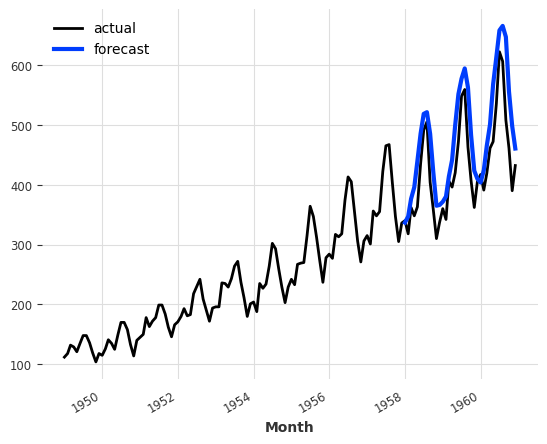

In [18]:
series.plot(label='actual')
model_tide.plot(label='forecast', lw=3)
plt.legend()

In [20]:
from darts.models import Prophet

models = [ExponentialSmoothing(),
          NHiTSModel(input_chunk_length=6,
            output_chunk_length=6),
          TiDEModel(
            input_chunk_length=24,
            output_chunk_length=12)]

backtests = [model.historical_forecasts(series,
                            start=.5,
                            forecast_horizon=3)
             for model in models]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 811 K 
---------------------------------------------------
807 K     Trainable params
3.1 K     Non-trainable params
811 K     Total params
3.244     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
---------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


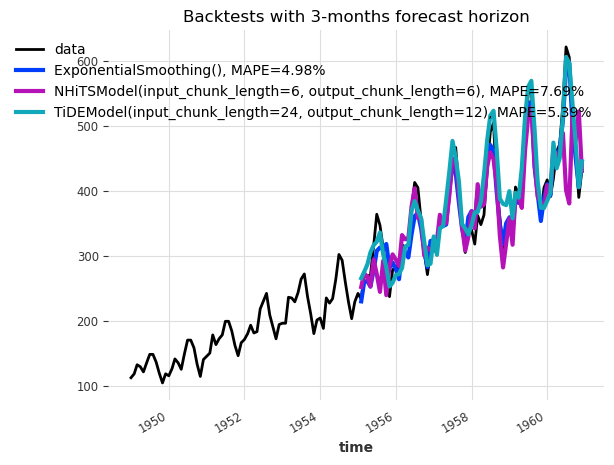

In [21]:
from darts.metrics import mape

series.plot(label='data')
for i, m in enumerate(models):
    err = mape(backtests[i], series)
    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))

plt.title('Backtests with 3-months forecast horizon')
plt.legend()